In [1]:
# Import Libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt #Added matplotlib
from census import Census
from pathlib import Path

In [2]:
# Use Path to open csvs.
laws_path = Path('Resources/CDC_Nutrition__Physical_Activity__and_Obesity_-_Legislation.csv')
deaths_path = Path('Resources/NCHS_-_Leading_Causes_of_Death__United_States.csv')
pop_path = Path('Resources/sc-est2017-alldata5.csv')

In [3]:
# Use Pandas to the read Legislature data.
laws_df = pd.read_csv(laws_path)

# Cleaning Data Set
laws_df = laws_df.drop(columns = ['Quarter', 'DataSource', 'Comments', 'EnactedDate', 'EffectiveDate', 
                                  'GeoLocation', 'PolicyTypeID', 'HealthTopicID', 'PolicyTopicID', 'Title',
                                 'SettingID', 'ProvisionID', 'Citation','StatusAltValue','DataType','DisplayOrder'])
laws_df = laws_df.rename(columns={'LocationAbbr': 'StateAbbr',
                                 'LocationDesc': 'State'})

laws_df.head()

,Year,StateAbbr,State,HealthTopic,PolicyTopic,Setting,Status
0,2009,CO,Colorado,Nutrition,Appropriations,School/After School,Enacted
1,2010,KY,Kentucky,Obesity,Food Restrictions,Community,Enacted
2,2010,KY,Kentucky,Physical Activity,Bicycling,Community,Enacted
3,2010,TX,Texas,Obesity,Sugar Sweetened Beverages,Early Care and Education,Enacted
4,2009,CO,Colorado,Nutrition,Agriculture and Farming,Community,Enacted


In [4]:
# Use Pandas to the read Legislature data
deaths_df = pd.read_csv(deaths_path)
deaths_df = deaths_df.rename(columns={'113 Cause Name': 'Full Cause Name',
                                     'State':'NAME'})
deaths_df['Year'] = deaths_df['Year'].astype('str')
deaths_df.dtypes

Year                        object
Full Cause Name             object
Cause Name                  object
NAME                        object
Deaths                       int64
Age-adjusted Death Rate    float64
dtype: object

In [5]:
# Grouping the population data frame to get sums for each year 
pop_df = pd.read_csv(pop_path)
pop_df = pop_df.drop(columns=['SUMLEV','REGION','DIVISION','STATE','SEX','ORIGIN','RACE','AGE','CENSUS2010POP','ESTIMATESBASE2010'])
grouped_pop = pop_df.groupby(['NAME'])

# Cleaning the grouped data frame
grouped_pop = grouped_pop[['POPESTIMATE2010','POPESTIMATE2011','POPESTIMATE2012','POPESTIMATE2013','POPESTIMATE2014',
                          'POPESTIMATE2015','POPESTIMATE2016','POPESTIMATE2017']].sum()
grouped_pop = grouped_pop.rename(columns={'POPESTIMATE2010':'2010','POPESTIMATE2011':'2011','POPESTIMATE2012':'2012',
                                          'POPESTIMATE2013':'2013','POPESTIMATE2014':'2014','POPESTIMATE2015':'2015',
                                          'POPESTIMATE2016':'2016','POPESTIMATE2017':'2017'})
grouped_pop = grouped_pop.reset_index()

# Setting up a new data frame to be able to merge the population with the deaths
merge_pop = pd.melt(grouped_pop, id_vars=["NAME"], var_name='Year', value_name='Population')

merge_pop.dtypes

NAME          object
Year          object
Population     int64
dtype: object

In [6]:
merged_df = pd.merge(merge_pop,deaths_df, on=(['NAME','Year']),how='left')
merged_df['Death Percentage'] = (merged_df['Deaths'] / merged_df['Population']) * 100
merged_df

,NAME,Year,Population,Full Cause Name,Cause Name,Deaths,Age-adjusted Death Rate,Death Percentage
0,Alabama,2010,19418292,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,2394,49.6,0.012329
1,Alabama,2010,19418292,All Causes,All causes,48038,939.7,0.247385
2,Alabama,2010,19418292,Alzheimer's disease (G30),Alzheimer's disease,1523,31.2,0.007843
3,Alabama,2010,19418292,Cerebrovascular diseases (I60-I69),Stroke,2619,51.6,0.013487
4,Alabama,2010,19418292,Chronic lower respiratory diseases (J40-J47),CLRD,2866,55.4,0.014759
...,...,...,...,...,...,...,...,...
4483,Wyoming,2017,2369120,"Diseases of heart (I00-I09,I11,I13,I20-I51)",Heart disease,1001,148.9,0.042252
4484,Wyoming,2017,2369120,Influenza and pneumonia (J09-J18),Influenza and pneumonia,115,17.5,0.004854
4485,Wyoming,2017,2369120,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,157,26.9,0.006627
4486,Wyoming,2017,2369120,Malignant neoplasms (C00-C97),Cancer,948,136.1,0.040015


In [7]:
#Filter df for only stroke for cause of death
stroke_df = merged_df.drop(merged_df[merged_df['Cause Name'] != 'Stroke'].index)
stroke_df = stroke_df.sort_values(by = ["NAME", "Year"])
stroke_df

,NAME,Year,Population,Full Cause Name,Cause Name,Deaths,Age-adjusted Death Rate,Death Percentage
3,Alabama,2010,19418292,Cerebrovascular diseases (I60-I69),Stroke,2619,51.6,0.013487
564,Alabama,2011,19481828,Cerebrovascular diseases (I60-I69),Stroke,2568,49.4,0.013182
1125,Alabama,2012,19554796,Cerebrovascular diseases (I60-I69),Stroke,2628,49.5,0.013439
1686,Alabama,2013,19620044,Cerebrovascular diseases (I60-I69),Stroke,2604,48.1,0.013272
2247,Alabama,2014,19679068,Cerebrovascular diseases (I60-I69),Stroke,2663,48.3,0.013532
...,...,...,...,...,...,...,...,...
2236,Wyoming,2013,2375636,Cerebrovascular diseases (I60-I69),Stroke,213,35.1,0.008966
2797,Wyoming,2014,2381044,Cerebrovascular diseases (I60-I69),Stroke,189,30.2,0.007938
3358,Wyoming,2015,2394136,Cerebrovascular diseases (I60-I69),Stroke,198,31.4,0.008270
3919,Wyoming,2016,2390424,Cerebrovascular diseases (I60-I69),Stroke,208,31.7,0.008701


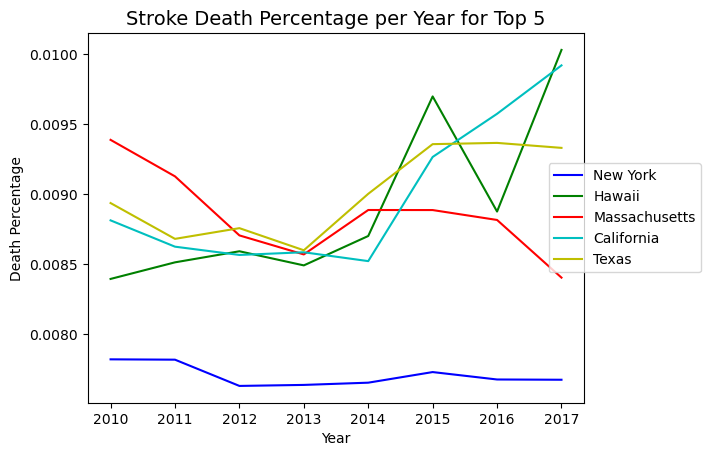

In [8]:
#Set parameters for state data
#Top 5 states for legislation passed
new_york = stroke_df.loc[stroke_df["NAME"]=="New York"]
hawaii = stroke_df.loc[stroke_df["NAME"]=="Hawaii"]
mass = stroke_df.loc[stroke_df["NAME"]=="Massachusetts"]
cali = stroke_df.loc[stroke_df["NAME"]=="California"]
texas = stroke_df.loc[stroke_df["NAME"]=="Texas"]

#Bottom 5 states for legislation passed
alaska = stroke_df.loc[stroke_df["NAME"]=="Alaska"]
wyoming = stroke_df.loc[stroke_df["NAME"]=="Wyoming"]
kansas = stroke_df.loc[stroke_df["NAME"]=="Kansas"]
s_dakota =stroke_df.loc[stroke_df["NAME"]=="South Dakota"]
n_dakota = stroke_df.loc[stroke_df["NAME"]=="North Dakota"]

#Make a line graph fot Top 5 states for stoke
plt.plot(new_york["Year"], new_york["Death Percentage"], color = "b", label = "New York")
plt.plot(hawaii["Year"], hawaii["Death Percentage"], color = "g", label = "Hawaii")
plt.plot(mass["Year"], mass["Death Percentage"], color = "r", label = "Massachusetts")
plt.plot(cali["Year"], cali["Death Percentage"], color = "c", label = "California")
plt.plot(texas["Year"], texas["Death Percentage"], color = "y", label = "Texas")
plt.title("Stroke Death Percentage per Year for Top 5", fontsize = 14)
plt.xlabel("Year")
plt.ylabel("Death Percentage")
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()

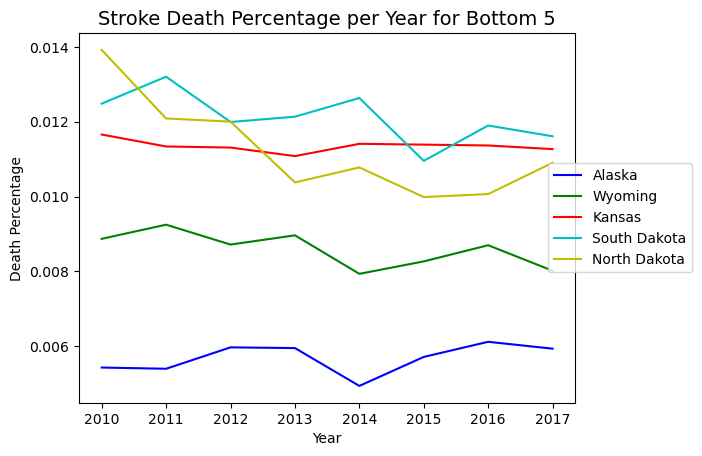

In [9]:
#Make line graph for bottom 5 states for stroke
plt.plot(alaska["Year"], alaska["Death Percentage"], color = "b", label = "Alaska")
plt.plot(wyoming["Year"], wyoming["Death Percentage"], color = "g", label = "Wyoming")
plt.plot(kansas["Year"], kansas["Death Percentage"], color = "r", label = "Kansas")
plt.plot(s_dakota["Year"], s_dakota["Death Percentage"], color = "c", label = "South Dakota")
plt.plot(n_dakota["Year"], n_dakota["Death Percentage"], color = "y", label = "North Dakota")
plt.title("Stroke Death Percentage per Year for Bottom 5", fontsize = 14)
plt.xlabel("Year")
plt.ylabel("Death Percentage")
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()

In [10]:
# Grouping the laws data frame to get counts
grouped_laws = laws_df.sort_values(by = ['State','HealthTopic'])
grouped_laws = grouped_laws.groupby(['State','Year','HealthTopic'])

laws_per_year = grouped_laws.count()
laws_per_year = laws_per_year.drop(columns=['StateAbbr', 'PolicyTopic','Setting'])
laws_per_year = laws_per_year.rename(columns={'Status':'Count'})
laws_per_year

Count
State   Year HealthTopic             
Alabama 2001 Nutrition              8
        2002 Nutrition              8
        2003 Nutrition              1
             Physical Activity      2
        2004 Nutrition              3
...                               ...
Wyoming 2013 Nutrition              5
             Obesity                1
             Physical Activity      1
        2016 Physical Activity      1
        2017 Nutrition              2

[1372 rows x 1 columns]

In [11]:
#Filter df for only suicide for cause of death
suicide_df = merged_df.drop(merged_df[merged_df['Cause Name'] != 'Suicide'].index)
suicide_df = suicide_df.sort_values(by = ["NAME", "Year"])
suicide_df

,NAME,Year,Population,Full Cause Name,Cause Name,Deaths,Age-adjusted Death Rate,Death Percentage
8,Alabama,2010,19418292,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,679,14.0,0.003497
569,Alabama,2011,19481828,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,654,13.2,0.003357
1130,Alabama,2012,19554796,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,724,14.7,0.003702
1691,Alabama,2013,19620044,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,721,14.4,0.003675
2252,Alabama,2014,19679068,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,715,14.5,0.003633
...,...,...,...,...,...,...,...,...
2241,Wyoming,2013,2375636,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,129,21.5,0.005430
2802,Wyoming,2014,2381044,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,120,20.6,0.005040
3363,Wyoming,2015,2394136,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,157,28.0,0.006558
3924,Wyoming,2016,2390424,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,144,25.2,0.006024


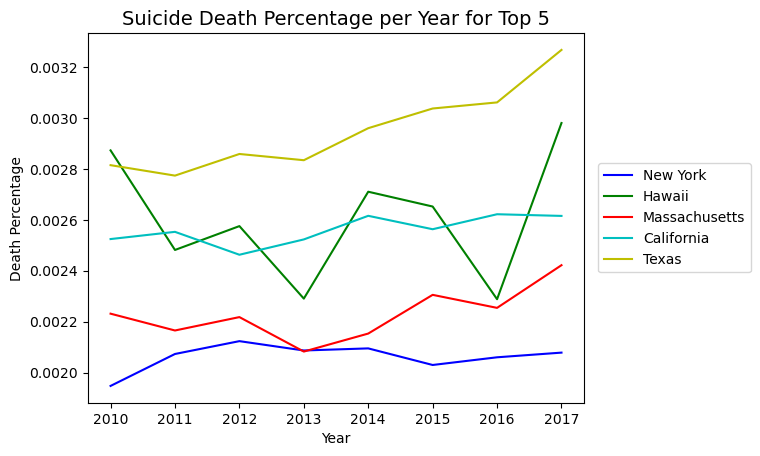

In [16]:
#Set parameters for state data
#Top 5 states for legislation passed
new_york = suicide_df.loc[suicide_df["NAME"]=="New York"]
hawaii = suicide_df.loc[suicide_df["NAME"]=="Hawaii"]
mass = suicide_df.loc[suicide_df["NAME"]=="Massachusetts"]
cali = suicide_df.loc[suicide_df["NAME"]=="California"]
texas = suicide_df.loc[suicide_df["NAME"]=="Texas"]

#Bottom 5 states for legislation passed
alaska = suicide_df.loc[suicide_df["NAME"]=="Alaska"]
wyoming = suicide_df.loc[suicide_df["NAME"]=="Wyoming"]
kansas = suicide_df.loc[suicide_df["NAME"]=="Kansas"]
s_dakota = suicide_df.loc[suicide_df["NAME"]=="South Dakota"]
n_dakota = suicide_df.loc[suicide_df["NAME"]=="North Dakota"]

#Make a line graph fot Top 5 states for suicide
plt.plot(new_york["Year"], new_york["Death Percentage"], color = "b", label = "New York")
plt.plot(hawaii["Year"], hawaii["Death Percentage"], color = "g", label = "Hawaii")
plt.plot(mass["Year"], mass["Death Percentage"], color = "r", label = "Massachusetts")
plt.plot(cali["Year"], cali["Death Percentage"], color = "c", label = "California")
plt.plot(texas["Year"], texas["Death Percentage"], color = "y", label = "Texas")
plt.title("Suicide Death Percentage per Year for Top 5", fontsize = 14)
plt.xlabel("Year")
plt.ylabel("Death Percentage")
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.show()

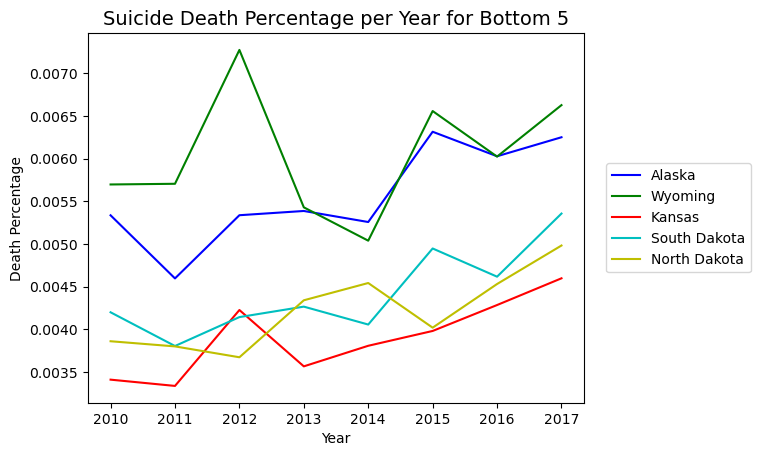

In [17]:
#Make line graph for bottom 5 states for suicide
plt.plot(alaska["Year"], alaska["Death Percentage"], color = "b", label = "Alaska")
plt.plot(wyoming["Year"], wyoming["Death Percentage"], color = "g", label = "Wyoming")
plt.plot(kansas["Year"], kansas["Death Percentage"], color = "r", label = "Kansas")
plt.plot(s_dakota["Year"], s_dakota["Death Percentage"], color = "c", label = "South Dakota")
plt.plot(n_dakota["Year"], n_dakota["Death Percentage"], color = "y", label = "North Dakota")
plt.title("Suicide Death Percentage per Year for Bottom 5", fontsize = 14)
plt.xlabel("Year")
plt.ylabel("Death Percentage")
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.show()